# 1.2 Marginal Gaussianization

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

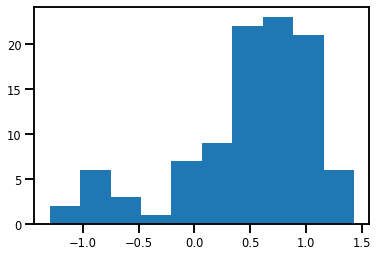

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/m61x60ug

In [4]:

# config parameters
wandb.config.n_samples = 1_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

<Figure size 432x288 with 0 Axes>

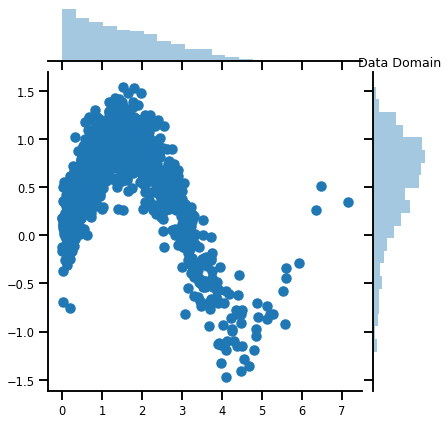

In [70]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plt.figure()
sns.jointplot(data[:, 0], X_approx[:, 1])
plt.title('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [7]:
from rbig_jax.transforms.histogram import get_hist_params
from rbig_jax.transforms.uniformize import uniformize_transform

## Marginal Transformation

(aka element-wise transformation)

#### Histogram

In [10]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(X_marg.shape[0]))

histogram_uniformize = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [76]:
from typing import Callable, List, NamedTuple
import collections
Params = collections.namedtuple(
    "Params", ["support", "quantiles", "support_pdf", "empirical_pdf"]
)


def marginal_transform_params(X, function: Callable):

    X, params = jax.vmap(function, out_axes=(0, 1))(X.T)
    return (
        np.stack(X, axis=1),
        Params(
            support=params.support.T,
            quantiles=params.quantiles.T,
            support_pdf=params.support_pdf.T,
            empirical_pdf=params.empirical_pdf.T,
        ),
    )

def marginal_transform(X, function: Callable, params: List[NamedTuple]) -> np.ndarray:

    X = jax.vmap(function, in_axes=(0, 0), out_axes=0)(X.T, params)

    return np.vstack(X).T

In [77]:
X_u, params = marginal_transform_params(data, histogram_uniformize)

<Figure size 432x288 with 0 Axes>

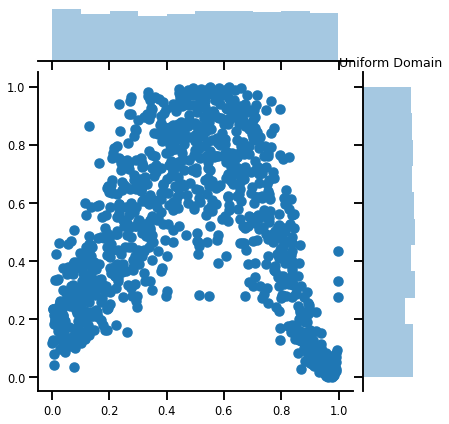

In [78]:
# plot data
plt.figure()
sns.jointplot(onp.array(X_u)[:, 0], onp.array(X_u)[:, 1])
plt.title('Uniform Domain')
plt.show()

#### JIT Compilation

In [79]:
marginal_transform_params_jitted = jax.jit(
    jax.partial(
        marginal_transform_params, 
        function=histogram_uniformize
    ))

In [80]:
_ = marginal_transform_params_jitted(data)

%timeit marginal_transform_params(np.array(data).block_until_ready(), histogram_uniformize)
%timeit marginal_transform_params_jitted(np.array(data).block_until_ready())

153 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
375 µs ± 37.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Marginal Gaussinization Transformation

In [81]:
from rbig_jax.transforms.gaussianize import gaussianize_forward

In [82]:
# define our marginal uniform transform dist
uni_transform_f = jax.partial(
        marginal_transform_params, 
        function=histogram_uniformize
    )

gaussianize_f = jax.partial(uni_gaussianize, uni_transform_f=uni_transform_f)
X_g, params = gaussianize_f(data)

<Figure size 432x288 with 0 Axes>

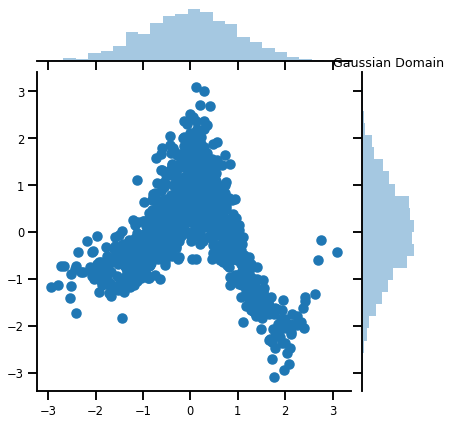

In [83]:
plt.figure()
sns.jointplot(onp.array(X_g)[:, 0], onp.array(X_g)[:, 1])
plt.title('Gaussian Domain')
plt.show()

### JITTED

In [84]:
# define our marginal uniform transform dist
uni_transform_f = jax.partial(
    marginal_transform_params, 
    function=histogram_uniformize
)

gaussianize_f = jax.partial(uni_gaussianize, uni_transform_f=uni_transform_f)
gaussianize_f_jitted = jax.jit(jax.partial(uni_gaussianize, uni_transform_f=uni_transform_f))
X_g, params = gaussianize_f_jitted(data)

In [85]:
X_g, params = gaussianize_f_jitted(data)
%timeit gaussianize_f(np.array(data).block_until_ready())
%timeit gaussianize_f_jitted(np.array(data).block_until_ready())

176 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
651 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Forward/Inverse Transformation

In [86]:
from rbig_jax.transforms.gaussianize import gaussianize_marginal_transform, gaussianize_marginal_inverse

In [87]:
gaussianize_f = jax.partial(uni_gaussianize, uni_transform_f=uni_transform_f)

In [88]:
X_g = gaussianize_marginal_transform(data, params)

<Figure size 432x288 with 0 Axes>

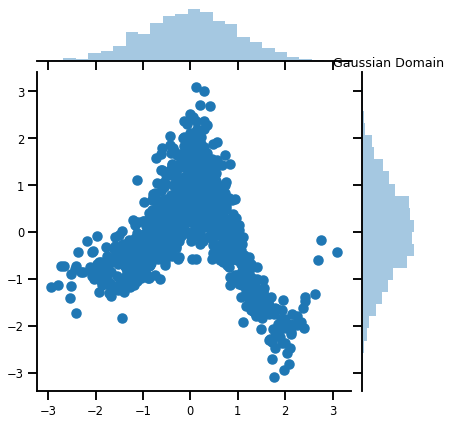

In [89]:
plt.figure()
sns.jointplot(onp.array(X_g)[:, 0], onp.array(X_g)[:, 1])
plt.title('Gaussian Domain')
plt.show()

In [90]:
X_approx = gaussianize_marginal_inverse(X_g, params)

Text(0.5, 1.0, 'Data Domain')

<Figure size 432x288 with 0 Axes>

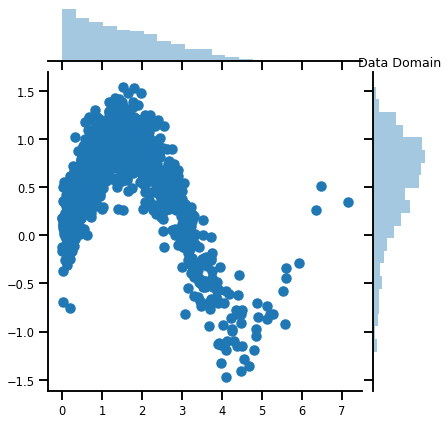

In [93]:
plt.figure()
sns.jointplot(X_approx[:, 0], X_approx[:, 1])
plt.title('Data Domain')